# Stratification for Variance Reduction 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The key idea in stratification is to split the domain on which we wish to calculate an expectation or integral into strata. Then, on each of these strata, we calculate the sub-integral as an expectation separately, using whatever method is appropriate for the stratum, and which gives us the lowest variance. These expectations are then combined together to get the final value.

In other words we can achieve better sampling in needed regions by going away from a one size fits all sampling scheme. One way to think about it is that regions with higher variability might need more samples, while not-so-varying regions could make do with less.

The diagram below illustrates this a bit. One could stratify by staying on the given grid, but the blue and yellow strata we have chosen might be better.

![](images/strat.png)

## Why does stratification decrease variance?

Intuitively, smaller samples have less variance. And stratification lets us do designer sampling in the strata. But lets do the math...

Start by considering a one-dimensional expectation, over some region $D$ (could be [0,1]):

$$ \mu = \int_{D} h(x) f(x)\, dx $$

where $f(x)$ is a pdf normalized over the support D.

We'll use the notation $\hat{\mu}$ to refer to a monte-carlo sample average. The hat ($^$) denotes that it is an estimator of $\mu$, the "population" average (you could think of the infinite limit as the population).

Then:

$$\hat{\mu} =  (1/N) \sum_{x_k \sim f} h(x_k); E_R[\hat{\mu}] = \mu.$$

Here $E_R[.]$ is the expectation with respect to the sampling (or replications or bootstrap) distribution.

Now, instead of taking $N$ samples, we break the interval into $M$ _strata_ and take $n_j$ samples for each
strata $j$, such that $N=\sum_j n_j$.

$$\mu = \int_D h(x) f(x) dx = \sum_j \int_{D_j} h(x) f(x) dx$$

Define the probability of being in region $D_j$ as $p_j$. Then this must be:

$$p_j = \int_{D_j} f(x) dx$$.

We can define a re-normalized pdf in the $j$th strata then as:

$$f_j(x) = \frac{f(x)}{p_j}$$.

Then

$$\mu =  \sum_j p_j \int_{D_j} h(x) \frac{f(x)}{p_j} dx = \sum_j p_j \mu_j,$$

where

$$\mu_j = \int_{D_j} h(x) f_j(x) dx$$

is the expectation value under pdf $f_j$ of $h(x)$ in region $D_j$.

We can estimate this with monte-carlo by:

$$\hat{\mu_j} = \frac{1}{n_j} \sum_{x_ij \sim f_j} h(x_ij).$$

Let us now define the stratified estimator of the overall expectation

$$\hat{\mu_s} = \sum_j p_j \hat{mu_j}.$$

Taking the expectation with respect to the sampling distribution then gives us:

$$E_R[\hat{\mu_s}] = \sum_j p_j E_R[\hat{mu_j}] = \sum_j p_j \mu_j = \mu$$

and thus $\hat{\mu_s}$ is an unbiaded estimator of $\mu$. Yay! We are on the right track.

But what about the variance?

$$Var_R[\hat{\mu_s}] =  Var_R[\sum_j p_j \hat{\mu_j}] =  \sum_j p_j^2 Var_R[\hat{\mu_j}] =  \sum_j p_j^2 \frac{\sigma_j^2}{n_j} $$

where

$$\sigma_j^2 = \int_{D_j}  (h(x) - \mu_j)^2 f_j(x) dx = \int_{D_j}  h(x)^2$$

is the "population variance" of $h(x)$ with respect to pdf $f_j(x)$ in region of support $D_j$.

How does this variance compare to the variance  of the standrd Monte Carlo estimator $\hat{\mu}$? Lets calculate this.

$$Var_R[\hat{\mu}] = \frac{\sigma^2}{N}$$

where $\sigma^2$ if the population variance of $h(x)$ on all od $D$ with respect to pdf $f(x)$.

$$Var_R[\hat{\mu}] = \frac{1}{N} \int_D (h(x) - \mu)^2 f(x) dx$$

$$ = \frac{1}{N} \sum_j p_j \int_{D_j} (h(x) - \mu)^2 f_j(x) dx =  \frac{1}{N}  \sum_j p_j \left(\int_{D_j} h(x)^2 f_j(x) dx + \mu^2 \int_{D_j}f_j(x) dx -2\mu\int_{D_j}h(x)f_j(x)dx \right)$$

$$ Var_R[\hat{\mu}] =  \frac{1}{N}\left(\sum_j p_j  \int_{D_j} h(x)^2 f_j(x) dx  - mu^2 \right)$$

The integral on the right can be substituted for using the formula for $\sigma_j$ above  and we get:

$$ Var_R[\hat{\mu}]  = \frac{1}{N}\left(\sum_j p_j [\sigma_j^2 + \mu_j^2] - \mu^2 \right)$$

Now note that we found:

$$Var_R[\hat{\mu_s}] =  \sum_j p_j^2 \frac{\sigma_j^2}{n_j} $$

If we assume (a ok assumption as it allocates samples to the strata on the probability of being there but not based on the variance) that

$$n_j = p_j N$$

we get:

$$ Var_R[\hat{\mu}]  = \frac{1}{N} \sum_j p_j \sigma_j^2 + \frac{1}{N} \left(\sum_j p_j \mu_j^2 - \mu^2 \right) $$ which is the  stratified variance plus a quantity that can be be shown to be positive by the cauchy schwartz equality.

## Example

For a  one-dimensional application we take $ x/(x^2+1)$ and integrate from $[0,1]$.
We break $[0,10]$ into $M$ strata and for each stratum, take $N/M$ samples
with uniform probability distribution. Compute the average within each 
stratum, and then calculate the overall average. 

C:\Users\Bri\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


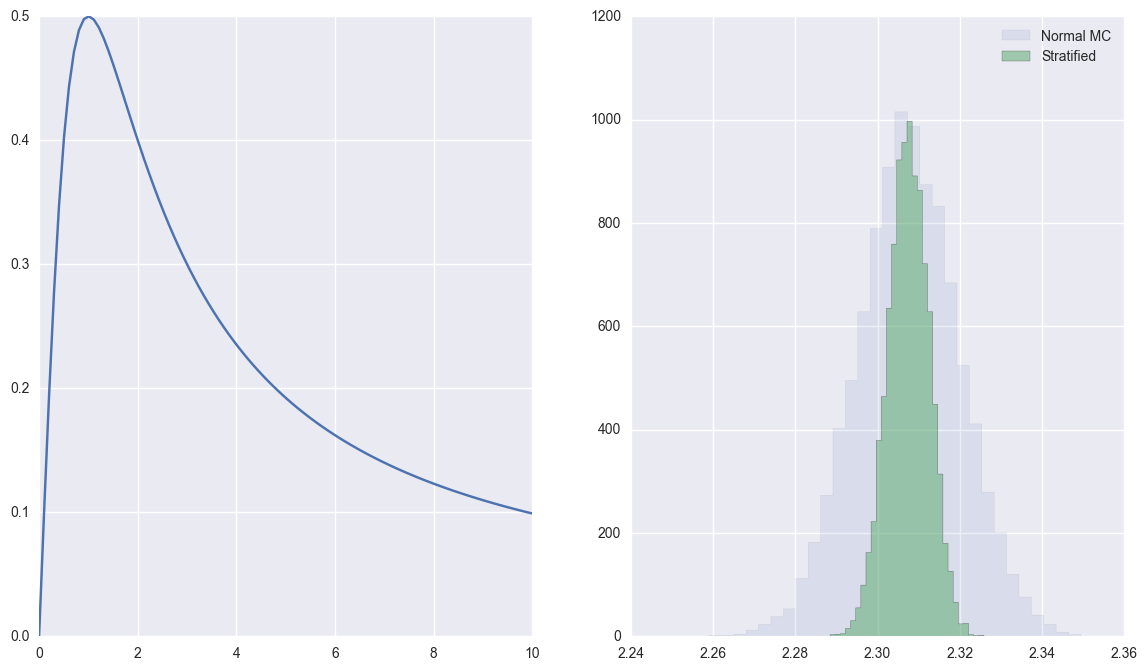

In [4]:
plt.figure(figsize=[14,8])
Y = lambda x: x/(x**2+1.0);
intY = lambda x: np.log(x**2 + 1.0)/2.0;

## Ploting the original functions 
plt.subplot(1,2,1)
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$x/(x**2+1)$')

N= 10000
M = 10   # number of strate 

xmin=0
xmax =10

# analytic solution 
Ic = intY(xmax)-intY(xmin)

Imc = np.zeros(N)
Is = np.zeros(N)
for k in np.arange(0,N): # do it k times...= 10,000 this time bc of N
 
    Umin=0
    Umax =10
    # First lets do it with mean MC method 
    U = np.random.uniform(low=Umin, high=Umax, size=N)
    Imc[k] = (Umax-Umin)* np.mean(Y(U)) # multiply by the sample mean

    #stratisfied it in Ns regions
    step = (Umax-Umin )/M
    Umin = 0 
    Umax = step
    Ii = 0
    
    
    for reg in np.arange(0,M):
        x = np.random.uniform(low=Umin, high=Umax, size=1.0*N/Ns);
        Ii = Ii+(Umax-Umin)* np.mean(Y(x))
        Umin = Umin + step
        Umax = Umin + step


    Is[k] = Ii

plt.subplot(1,2,2)
plt.hist(Imc,30, histtype='stepfilled', label=u'Normal MC', alpha=0.1)
plt.hist(Is, 30, histtype='stepfilled', label=u'Stratified', alpha=0.5)
plt.legend()

